# Initial Modeling

For initial modeling, I've implemented a CNN autoencoder to learn latent features corresponding to MRI scans containing brain tumors. The model will be trained on its ability to reconstruct batches of tumor images. The loss function used is structural similarity index measure which measures the similarity between two images. I'll provide a more in depth description on the loss function in later updates. 

The model architecture uses a encoder-decoder framework where the number of channels and kernel size increase with each layer in the encoder and decreases in the same fashion for the decoder network. This performs a compression-expansion transformation of the data in order to preserve the key features of each image.

In [1]:
!pip install torchinfo
!pip install pytorch-msssim

In [28]:
import os  
import glob
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

import PIL 
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image

# torch-based imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary 
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pytorch_msssim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [5]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [50]:
main_path = '/content/drive/MyDrive/Academic/Spring 2022/MA 544 Linear Algebra/Anomaly-Detection-Numerical-LinAlg-for-Big-Data/MRIscans'

train_path =  main_path + '/Training/'
val_path = main_path + '/Validation/'
test_path = main_path + '/Testing/'

train_files = glob.glob(os.path.join(train_path, "tumor",'*.*'))
val_files = glob.glob(os.path.join(val_path, '*.*'))

test_files_pos = glob.glob(os.path.join(test_path, 'tumor_test', '*.*'))
test_files_neg = glob.glob(os.path.join(test_path, 'no_tumor', '*.*'))
test_files = test_files_pos + test_files_neg

test_labels = np.array([0]*len(test_files_pos)+[1]*len(test_files_neg))

In [7]:
print(f'Number of training files: {len(train_files)}')
print(f'Number of validation files: {len(val_files)}')
print(f'Number of test files: {len(test_files)}')

print(f'\nNumber of tumor images in test set: {len(test_files_pos)}')
print(f'Number of non-tumor images in test set: {len(test_files_neg)}')

Number of training files: 5360
Number of validation files: 1428
Number of test files: 3978

Number of tumor images in test set: 1345
Number of non-tumor images in test set: 2633


## Dataset Class

In [27]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, test=False, labels=None, img_transforms=None, grayscale=True):
        
        self.img_path = img_path
        self.test = test 
        self.labels = labels 

        # Default Transforms
        if img_transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((250, 250)),
                                                  ])
        # Custom Transforms
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load images
        cur_path = self.img_path[index]
        cur_img = cur_img = PIL.Image.open(cur_path).convert('L')
        cur_img = self.transforms(cur_img)

        if self.test:
            return cur_img, self.labels[index]

        else:
            return cur_img
    
    def __len__(self):
        return len(self.img_path)

## Initial Architecture

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1,output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.float()
        x = self.decoder(x)
        return x

## CNN Autoencoder Training Function

In [22]:
def train_model(model, train_dataset, val_dataset, device, lr=0.0001, 
                epochs=30, batch_size=32, l2=0.00001, gamma=0.5, patience=7):
    
    model = model.to(device)
    
    # construct dataloader to iterate through batches of images
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # history
    history = {'train_loss': [],
               'val_loss': []}            
    
    # set up loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        val_loss = 0

        for i, images in enumerate(train_loader):
            images = images.to(device)
            
            outputs = model(images)
            cur_train_loss = 1 - pytorch_msssim.ssim(images, outputs)
            
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

            # loss
            train_loss += cur_train_loss 
            
        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for i, images in enumerate(val_loader):
                # calculate validation loss
                images = images.to(device)

                outputs = model(images)
                
                # loss
                cur_valid_loss = 1-pytorch_msssim.ssim(images, outputs)
                val_loss += cur_valid_loss

        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f}, val loss:{val_loss:.5f}")
        
        # update history
        
        history['train_loss'].append(train_loss.cpu().item())
        history['val_loss'].append(val_loss.cpu().item())
    
    return history

In [23]:
train_dataset = CT_Dataset(img_path=train_files)
val_dataset = CT_Dataset(img_path=val_files)

model = Autoencoder()

In [24]:
summary(model, (32, 1, 250, 250)) # shape --> (batch size, num_channels, img_height, img_width)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              --                        --
├─Sequential: 1-1                        [32, 64, 57, 57]          --
│    └─Conv2d: 2-1                       [32, 16, 125, 125]        160
│    └─ReLU: 2-2                         [32, 16, 125, 125]        --
│    └─Conv2d: 2-3                       [32, 32, 63, 63]          4,640
│    └─ReLU: 2-4                         [32, 32, 63, 63]          --
│    └─Conv2d: 2-5                       [32, 64, 57, 57]          100,416
├─Sequential: 1-2                        [32, 1, 250, 250]         --
│    └─ConvTranspose2d: 2-6              [32, 32, 63, 63]          100,384
│    └─ReLU: 2-7                         [32, 32, 63, 63]          --
│    └─ConvTranspose2d: 2-8              [32, 16, 125, 125]        4,624
│    └─ReLU: 2-9                         [32, 16, 125, 125]        --
│    └─ConvTranspose2d: 2-10             [32, 1, 250, 250]         1

In [25]:
hist = train_model(model, train_dataset, val_dataset, device, batch_size=120, epochs=10)

Training Start:
Epoch:1 / 10, train loss:0.01535, val loss:0.01049
Epoch:2 / 10, train loss:0.00533, val loss:0.00383
Epoch:3 / 10, train loss:0.00300, val loss:0.00315
Epoch:4 / 10, train loss:0.00255, val loss:0.00273
Epoch:5 / 10, train loss:0.00213, val loss:0.00213
Epoch:6 / 10, train loss:0.00152, val loss:0.00158
Epoch:7 / 10, train loss:0.00104, val loss:0.00116
Epoch:8 / 10, train loss:0.00073, val loss:0.00090
Epoch:9 / 10, train loss:0.00056, val loss:0.00076
Epoch:10 / 10, train loss:0.00047, val loss:0.00066


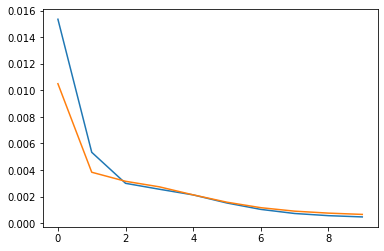

In [26]:
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.show()

In [51]:
def get_reconstruction_err(test_data, model):
    
    error = {'pred_loss':[], 'label':[]}
    
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)
        
        for image_, label in test_loader:
            image_ = image_.to(device)
            outputs = model(image_)
            loss = 1 - pytorch_msssim.ssim(image_, outputs)
            error['pred_loss'].append(loss.cpu().item())
            error['label'].append(label.cpu().item())

    recon_err = pd.DataFrame(error)
    
    return recon_err

In [52]:
test_dataset = CT_Dataset(test_files, test=True, labels=test_labels)

In [53]:
recon_error = get_reconstruction_err(test_dataset, model)

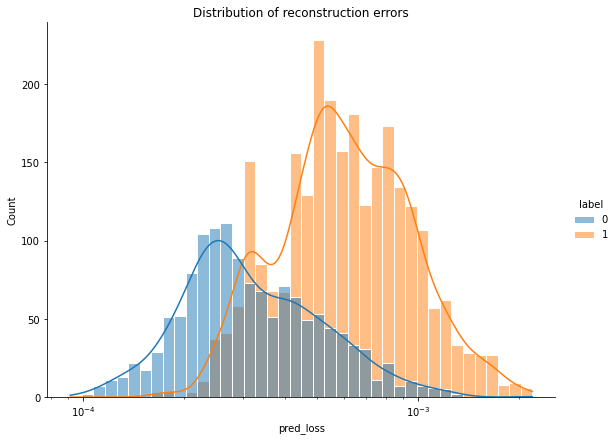

In [54]:
import seaborn as sns
sns.displot(recon_error, x='pred_loss',kde=True, hue='label', bins=40, log_scale=[True, False], height=6, aspect=8/6, edgecolor='white')
plt.title('Distribution of reconstruction errors')
plt.show()

In [55]:
def plot_auc_roc(tpr, fpr, roc_auc):
    
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'Reciever Operating Characteristic Curve -- AUC: {roc_auc:.3f}')
    plt.show()

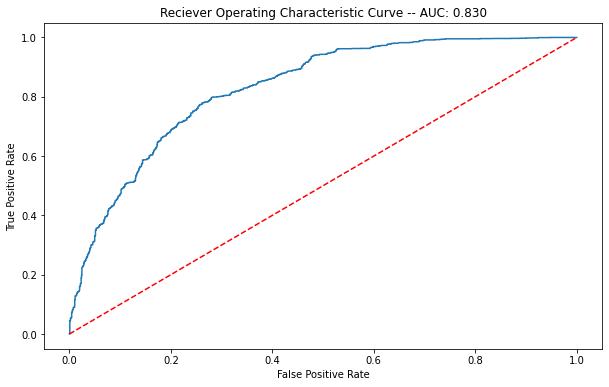

In [58]:
from sklearn.metrics import roc_curve, auc, classification_report

fpr, tpr, thresholds = roc_curve(recon_error.label , recon_error.pred_loss)
roc_auc = auc(fpr, tpr)

plot_auc_roc(tpr, fpr, roc_auc)

In [59]:
best_thres_idx = np.argmax(tpr-fpr)
best_thres = thresholds[best_thres_idx]

recon_error['Pred'] = np.where(recon_error['pred_loss'] <= best_thres, 0, 1)

print(best_thres)

0.00041854381561279297


In [60]:
print(classification_report(recon_error['Pred'], recon_error['label']))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1502
           1       0.80      0.85      0.82      2476

    accuracy                           0.77      3978
   macro avg       0.76      0.75      0.75      3978
weighted avg       0.77      0.77      0.77      3978

